Load the data set

In [6]:
import tensorflow as tf
from itertools import compress
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [7]:
#load data
def load_data(names):
    """ loads data 
    
    Attribut:
        names: list of data names
        
    Returns concatenated data with the shape of (#observations,13)
    index: 
        0:   Elapsed time (sec)
        1:   Top left corner x coordinate (px)
        2:   Top left corner y coordinate (px)
        3:   Lower right corner x coordinate (px)
        4:   Lower right corner y coordinate (px)
        5:   Distance traveled (m)
        6:   Spacing to the rear bumper of the front vehicle (m)
        7:   Velocity estimated from camera (m/s)
        8:   Acceleration (m/s2)
        9:   Fuel rate recorded from OBD (l/h)
        10:  Velocity recorded from OBD (m/s)
        11:  Estimated acceleration from the camera velocity (m/s2)
        12:  Leader's velocity estimated from camera (m/s)
        13:  Leader's velocity recorded from OBD (m/s)
    """
    data = np.empty((0,14))  
    for name in names:
        exp_data = loadmat('{}_processed.mat'.format(name))["data"]
        exp_data = np.swapaxes(exp_data,0,1) # now first dim is veh #
        exp_data_reshaped = exp_data.reshape(
                exp_data.shape[0] * exp_data.shape[1], exp_data.shape[2])
        data = np.append(data,exp_data_reshaped,axis=0)  
    return data

# training_experiments = ["expA", "expB", "expC", "expD", "expE", "expF"]               
# train_set = load_data(training_experiments)
# features_target = [0,7,12,6,8] # time, speed, lead_speed, gap, acceleration
# train_set = train_set[:,features_target]
# train_set = train_set[~np.isnan(train_set).any(axis=1)]

# test_experiments = ["expG", "expH"]                 
# test_set = load_data(test_experiments)
# test_set = test_set[:,features_target]
# test_set = test_set[~np.isnan(test_set).any(axis=1)]

In [8]:
data_A = load_data(["expA"])
data_A


array([[ 0.00000000e+00,  3.79400000e+03,  3.00000000e+01, ...,
                    nan, -2.54393887e-02,  0.00000000e+00],
       [ 3.33333333e-02,  3.79400000e+03,  3.00000000e+01, ...,
         1.77580489e-02, -2.62702534e-02,  0.00000000e+00],
       [ 6.66666667e-02,  3.79400000e+03,  3.00000000e+01, ...,
         1.74031129e-02, -2.70820901e-02,  0.00000000e+00],
       ...,
       [ 4.15900000e+02,  4.71000000e+02,  2.60000000e+01, ...,
        -6.33001185e-02,  1.23536896e-02,  8.33334000e-01],
       [ 4.15933333e+02,  4.71000000e+02,  2.60000000e+01, ...,
        -6.02392368e-02,  1.02214027e-02,  8.33334000e-01],
       [ 4.15966667e+02,  4.71000000e+02,  2.60000000e+01, ...,
        -5.72273781e-02,  8.18624926e-03,  8.33334000e-01]])

In [14]:
def split_data(training_experiments, test_experiments, last_acc=True, speed_limit=30):
    """
    """
    features_target = [0,7,12,6,6,8]  # time, speed, lead_speed, gap, added for speed limit, added for prev acc ,acceleration
    
    # training set
    train_set = load_data(training_experiments)
    train_set = train_set[:,features_target]
    train_set = train_set[~np.isnan(train_set).any(axis=1)]
    
    # test set   
    test_set = load_data(test_experiments)
    test_set = test_set[:,features_target]
    test_set = test_set[~np.isnan(test_set).any(axis=1)]
    
    if last_acc:
        # add a new column for the acceleration during the previous step
#         prev_acc_train = np.zeros((train_set.shape[0],1))
#         prev_acc_train[1:,0] = train_set[:-1,4] 
#         train_set = np.hstack((train_set,prev_acc_train))
        train_set[1:,4] = train_set[:-1,5] 
        train_set = train_set[1:,:]  # remove the first row (no prev acceleration)
        
#         prev_acc_test = np.zeros((test_set.shape[0],1))
#         prev_acc_test[1:,0] = test_set[:-1,4] 
#         test_set = np.hstack((test_set,prev_acc_test))
        test_set[1:,4] = test_set[:-1,5] 
        test_set = test_set[1:,:]  # remove the first row (no prev acceleration)

        
#         speed_limit_train = np.zeros((train_set.shape[0],1))
#         speed_limit_train[:] = speed_limit 
#         train_set = np.hstack((train_set,speed_limit_train))

#         # add a new column for the acceleration during the previous step
#         speed_limit_test = np.zeros((test_set.shape[0],1))
#         speed_limit_test[:] = speed_limit 
#         test_set = np.hstack((test_set,speed_limit_test))

    return train_set, test_set


#add a column for the previous acceleration (1 step RNN)
training_experiments = ["expA", "expB", "expC", "expD", "expE", "expF"] 
test_experiments = ["expG", "expH"]    
train_set, test_set = split_data(training_experiments, test_experiments)
train_set = train_set.astype(np.float32)
test_set = test_set.astype(np.float32)


# train_set = load_data(training_experiments)
# features_target = [0,7,12,6,8,10] # time, speed, lead_speed, gap, acceleration, additional col
# train_set = train_set[:,features_target]
# train_set = train_set[~np.isnan(train_set).any(axis=1)]
# train_set[:,5] = 0
# train_set[1:,5] = train_set[:-1,4] # previous acc
# train_set = train_set[1:,:]

             
# test_set = load_data(test_experiments)
# test_set = test_set[:,features_target]
# test_set = test_set[~np.isnan(test_set).any(axis=1)]
# test_set[:,5] = 0
# test_set[1:,5] = test_set[:-1,4] 
# test_set = test_set[1:,:]


In [15]:
train_set.shape

(1362839, 6)

In [42]:
class SingleTaskNetwork:
    """
    Creates a NN for single task

    """
    def __init__(self, size, act_funcs, input_ph, col_num, dropout=False, batch_norm=False):
        """
        Parameters
        ----------
        size: list of ints
            list of units in hidden layers and output layer 
            The last element should be the output size, example: [128,128,1]
        act_funcs: list of tf.nn activation funcitons
            list of activation functions for each layer, 
            Size of the list should be number of hidden layers + 1, 
            the last element should be the output activation function, example: [tf.nn.relu,tf.nn.relu, None]
        input_ph: tf placeholder
            TensorFlow placeholder for the inputs
        col_num: int
            column number
        dropout: boolean, optional
            specifies whether to use dropout
        batch_norm: boolean, optional
            specifies whether to use batch normalization
        """
        self.size = size
        self.act_funcs = act_funcs
        self.input_ph = input_ph
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.weights = []
        self.biases = []
        self.h = [self.input_ph]
        self.col_num = col_num

    def create_single_task_nn(self):
        """ Creates a the neural network for regression problem

        Returns
        ----------
        output_layer: Output layer prediction
        """      
        last_layer = self.input_ph

        scope = "nn"
        if self.dropout:
            scope += "_d"
        if self.batch_norm:
            scope += "bn"
            
        # create variables
        with tf.variable_scope('column_{}'.format(self.col_num), reuse=tf.AUTO_REUSE):
            for layer in range(len(self.size)):
                if layer == 0:  # input layer
                    self.weights.append(tf.get_variable(name='W{}_{}'.format(layer, self.col_num), 
                                                   shape=[self.input_ph.shape[1], self.size[0]], 
                                                   initializer=tf.contrib.layers.xavier_initializer()))
                    self.biases.append(tf.get_variable(name='b{}_{}'.format(layer, self.col_num), 
                                                  shape=[self.size[0]], 
                                                  initializer=tf.constant_initializer(0.)))
                else:   # hidden and output layers
                    shape = self.size[layer-1:layer+1]
                    self.weights.append(tf.get_variable(name='W{}_{}'.format(layer, self.col_num), 
                                                   shape=shape, 
                                                   initializer=tf.contrib.layers.xavier_initializer()))
                    self.biases.append(tf.get_variable(name='b{}_{}'.format(layer, self.col_num), 
                                                  shape=shape[1], 
                                                  initializer=tf.constant_initializer(0.)))

        # create computation graph
        i = 0
        for W, b, act_func in zip(self.weights, self.biases, self.act_funcs):
            last_layer = tf.matmul(last_layer, W) + b
            self.h.append(last_layer)
            if act_func is not None:
                last_layer = act_func(last_layer)
            if self.dropout:
                last_layer = tf.nn.dropout(last_layer, 0.5)
            if self.batch_norm:
                last_layer = tf.contrib.layers.batch_norm(last_layer, 
                                                          center=True, scale=True, 
                                                          scope="{}_{}".format(scope,i), 
                                                          reuse=tf.AUTO_REUSE)
            i += 1
        self.output_pred = last_layer
        output_mean = last_layer[:, :-1]
        output_logstd = last_layer[:, -1:]
        pred = output_mean + tf.exp(output_logstd) * tf.random_normal([1])

        return pred, output_mean, output_logstd
        
#         return self.output_pred
    
    

In [68]:
###########################################################
########### Part 4. Single Task Network ###########
###########################################################
BATCH_SIZE = 1000
NUM_SGD_STEPS = 1500

tf.reset_default_graph()

# state and action placeholders
output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
input_ph = tf.placeholder(dtype=tf.float32, shape=[None, train_set.shape[1]-2])

# session
sess = tf.Session()

# function approximator
size = [128,128,128,2]
act_funcs = [tf.nn.leaky_relu,tf.nn.leaky_relu,tf.nn.leaky_relu,None]
col_num = 0
obj = SingleTaskNetwork(size, act_funcs, input_ph,col_num, batch_norm = True)
pred, output_mean, output_logstd = obj.create_single_task_nn()
# func_approx = tf.distributions.Normal(loc=model_output[0], scale=[1])

# loss
loss_mse = tf.reduce_mean(0.5 * tf.square(output_ph - pred))

# loss
# gaussian_dist = tf.contrib.distributions.Normal(loc=model_output[:,0], scale=model_output[:,1])
# log_prob = gaussian_dist.log_prob(value=test_set[:,-1:])

p = tf.contrib.distributions.MultivariateNormalDiag(
    loc=output_mean,
    scale_diag=tf.exp(output_logstd)
)
log_likelihoods = p.log_prob(output_ph)

# compute the loss and generate the optimizer
loss = -1.0 * tf.reduce_mean(log_likelihoods)




learning_rate = [0.005]  #[12e-3, 11e-3, 9e-3, 0.01]

res_dropout = []
min_error = float("inf")

source_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='column_{}'.format(0))
print ("source vars: ", source_vars)


for i in learning_rate:  # grid search
    res_dropout.append([])
    # optimizer
    opt = tf.train.AdamOptimizer(learning_rate= i).minimize(loss)

    # initialize all the variables
    sess.run(tf.global_variables_initializer())
    # create saver to save model variables
    saver = tf.train.Saver()

    for j in range(NUM_SGD_STEPS):  # train for num SGD steps
        # collect a batch of data
        indices = np.random.randint(low=0, 
                                    high=train_set.shape[0],
                                    size=BATCH_SIZE)
        obs = train_set[indices,1:-1]
        actions = train_set[indices,-1:]

        # compute the loss/return and update the weights of the policy
        _ = sess.run(opt, feed_dict={input_ph: obs, output_ph: actions})

        # compute the loss on the test set
        mse = sess.run(loss, feed_dict={input_ph: test_set[:10000,1:-1],
                                        output_ph: test_set[:10000,-1:]})

        res_dropout[-1].append(mse)
        
        if mse < min_error:
            min_error = mse
            best_learning_rate = i
        print(i, j, mse)
#     saver.save(sess, '/home/yashar/Dropbox/Berkeley/Projects/lord_of_the_ring/Data/tmp/model_PNN_task_0.ckpt')

print ("best_learning_rate: %s" % best_learning_rate)

source vars:  [<tf.Variable 'column_0/W0_0:0' shape=(4, 128) dtype=float32_ref>, <tf.Variable 'column_0/b0_0:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'column_0/W1_0:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'column_0/b1_0:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'column_0/W2_0:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'column_0/b2_0:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'column_0/W3_0:0' shape=(128, 2) dtype=float32_ref>, <tf.Variable 'column_0/b3_0:0' shape=(2,) dtype=float32_ref>]
0.005 0 8.545274
0.005 1 6.175552
0.005 2 5.674346
0.005 3 5.4292984
0.005 4 5.342309
0.005 5 5.319016
0.005 6 5.340579
0.005 7 5.374243
0.005 8 5.4122634
0.005 9 5.4498825
0.005 10 5.4775352
0.005 11 5.4949274
0.005 12 5.5113125
0.005 13 5.520928
0.005 14 5.527679
0.005 15 5.533202
0.005 16 5.536296
0.005 17 5.5312243
0.005 18 5.5248985
0.005 19 5.518469
0.005 20 5.511171
0.005 21 5.5023756
0.005 22 5.492737
0.005 23 5.483344
0.005 24 5.4724693
0.005 25 5.46

0.005 403 4.1962814
0.005 404 4.1972094
0.005 405 4.1979628
0.005 406 4.199231
0.005 407 4.2000084
0.005 408 4.2007403
0.005 409 4.2011695
0.005 410 4.1989546
0.005 411 4.1967587
0.005 412 4.1915836
0.005 413 4.1869726
0.005 414 4.182929
0.005 415 4.1794
0.005 416 4.1757364
0.005 417 4.172209
0.005 418 4.167998
0.005 419 4.1643467
0.005 420 4.1613483
0.005 421 4.1584826
0.005 422 4.1571345
0.005 423 4.155647
0.005 424 4.1542397
0.005 425 4.153207
0.005 426 4.15236
0.005 427 4.1513524
0.005 428 4.151211
0.005 429 4.151114
0.005 430 4.1509376
0.005 431 4.1507936
0.005 432 4.1508064
0.005 433 4.1509714
0.005 434 4.1510243
0.005 435 4.151122
0.005 436 4.1511064
0.005 437 4.1513104
0.005 438 4.1511936
0.005 439 4.1506596
0.005 440 4.150182
0.005 441 4.1494546
0.005 442 4.1487603
0.005 443 4.148216
0.005 444 4.1476865
0.005 445 4.1469803
0.005 446 4.146207
0.005 447 4.1455865
0.005 448 4.145075
0.005 449 4.1443205
0.005 450 4.1435895
0.005 451 4.14317
0.005 452 4.1427126
0.005 453 4.142435
0

0.005 826 3.7847192
0.005 827 3.7831
0.005 828 3.7813473
0.005 829 3.7796774
0.005 830 3.7776535
0.005 831 3.7753723
0.005 832 3.773289
0.005 833 3.7712274
0.005 834 3.7692282
0.005 835 3.7679029
0.005 836 3.7666903
0.005 837 3.7652874
0.005 838 3.7639024
0.005 839 3.7634766
0.005 840 3.7627187
0.005 841 3.7620401
0.005 842 3.7614195
0.005 843 3.7606246
0.005 844 3.7585895
0.005 845 3.7566578
0.005 846 3.7549222
0.005 847 3.7530668
0.005 848 3.751611
0.005 849 3.7511466
0.005 850 3.7505991
0.005 851 3.7496164
0.005 852 3.748829
0.005 853 3.7482114
0.005 854 3.7472243
0.005 855 3.7465653
0.005 856 3.7459157
0.005 857 3.7447095
0.005 858 3.744143
0.005 859 3.7434652
0.005 860 3.7425137
0.005 861 3.7411473
0.005 862 3.739943
0.005 863 3.738991
0.005 864 3.737739
0.005 865 3.7368703
0.005 866 3.7362773
0.005 867 3.7364573
0.005 868 3.736811
0.005 869 3.7363286
0.005 870 3.7358007
0.005 871 3.7356386
0.005 872 3.7354836
0.005 873 3.735512
0.005 874 3.7354238
0.005 875 3.7350953
0.005 876 3.

0.005 1232 3.4795382
0.005 1233 3.4793723
0.005 1234 3.4786906
0.005 1235 3.477818
0.005 1236 3.476618
0.005 1237 3.4748375
0.005 1238 3.4728405
0.005 1239 3.4710305
0.005 1240 3.4696133
0.005 1241 3.4677796
0.005 1242 3.4661741
0.005 1243 3.4648871
0.005 1244 3.4636414
0.005 1245 3.4620218
0.005 1246 3.4609118
0.005 1247 3.4610968
0.005 1248 3.4612582
0.005 1249 3.461528
0.005 1250 3.461903
0.005 1251 3.46243
0.005 1252 3.463086
0.005 1253 3.463543
0.005 1254 3.4638433
0.005 1255 3.463943
0.005 1256 3.463973
0.005 1257 3.4637845
0.005 1258 3.4634407
0.005 1259 3.462562
0.005 1260 3.4620702
0.005 1261 3.4611077
0.005 1262 3.4592586
0.005 1263 3.4574735
0.005 1264 3.455717
0.005 1265 3.4539645
0.005 1266 3.4526525
0.005 1267 3.4511695
0.005 1268 3.4495754
0.005 1269 3.4484425
0.005 1270 3.4468422
0.005 1271 3.4456758
0.005 1272 3.4445953
0.005 1273 3.4437199
0.005 1274 3.44328
0.005 1275 3.44265
0.005 1276 3.4420273
0.005 1277 3.4411886
0.005 1278 3.441086
0.005 1279 3.4410923
0.005 128

In [69]:
y_predicted_PNN = sess.run(pred, feed_dict={input_ph: test_set[:,1:-1]})

In [70]:
test_set[:,1:-1].shape


(729509, 4)

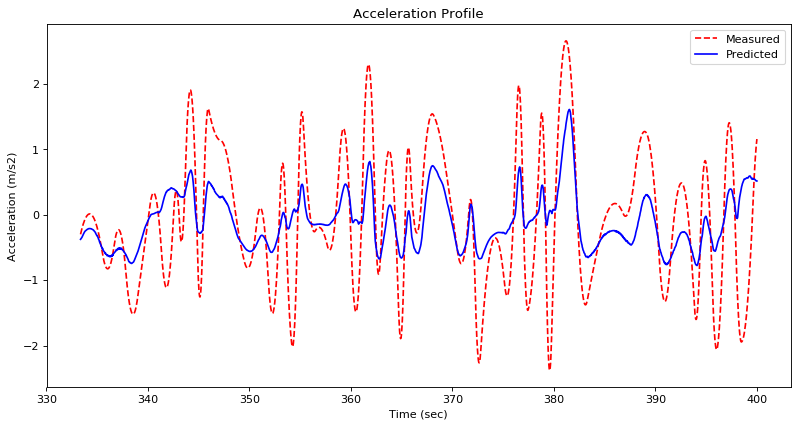

In [71]:
# plot data and prediction
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Acceleration Profile')
lower, upper = (10000, 12000)
plt.plot(test_set[lower:upper,0],test_set[lower:upper,-1:],'r--',label='Measured')
# plt.plot(test_data[lower:upper,0],y_default[lower:upper],'r-',label='Default')
plt.plot(test_set[lower:upper,0],y_predicted_PNN[lower:upper],'b-',label='Predicted')
#plt.plot(test_set[lower:upper,0],test_set[lower:upper,1],'g-',label='Speed')
#plt.plot(test_set[lower:upper,0],test_set[lower:upper,2],'g--',label='Leader Speed')
#plt.plot(test_set[lower:upper,0],test_set[lower:upper,3],'y-',label='Gap')
plt.ylabel('Acceleration (m/s2)')
plt.xlabel('Time (sec)')
plt.legend(loc='best')
plt.show()   